# State object

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pairinteraction.real as pi
from pairinteraction.visualization.colormaps import alphamagma

In [2]:
if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

# Create superposition state objects

In [3]:
# First create a ket of interest and a basis around this ket
ket = pi.KetAtom("Sr88_singlet", n=60, l=59, m=58)
print(f"Ket of interest: {ket}")
ket_energy = ket.get_energy(unit="GHz")
basis = pi.BasisAtom("Sr88_singlet", n=(ket.n - 3, ket.n + 3), l=(57, 60), m=(56, 60))
print(f"Number of basis states: {basis.number_of_states}")

# now with the ket and the basis we can define a state
state1 = pi.StateAtom(ket, basis)
# this state only has one entry in its coefficient vector
print(f"{state1.get_coefficients()=}")
# this can also be seen by just printing the state
print(f"State1: {state1}")

# To showcase addition, ... of two states we also define a second state
ket2 = pi.KetAtom("Sr88_singlet", n=60, l=58, m=58)
state2 = pi.StateAtom(ket2, basis)
print(f"State2: {state2}")

Ket of interest: |Sr88_singlet:60,59_59,58⟩
Number of basis states: 58
state1.get_coefficients()=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])
State1: StateAtom(1.00 |Sr88_singlet:60,59_59,58⟩)
State2: StateAtom(1.00 |Sr88_singlet:60,58_58,58⟩)


In [4]:
# now we can create a symmetric and anti-symmetric superposition of these two states
state_plus = (state1 + state2).normalize()
state_minus = (state1 - state2).normalize()
print(f"State plus: {state_plus}")
print(f"State minus: {state_minus}")

# and you can create any linear combination of as many states as you want
ket3 = pi.KetAtom("Sr88_singlet", n=60, l=57, m=57)
state3 = pi.StateAtom(ket3, basis)
print(f"{1.1 * state1 + 0.6 * state2 - 0.4 * state3 = }")

State plus: StateAtom(0.71 |Sr88_singlet:60,59_59,58⟩ + 0.71 |Sr88_singlet:60,58_58,58⟩)
State minus: StateAtom(0.71 |Sr88_singlet:60,59_59,58⟩ + -0.71 |Sr88_singlet:60,58_58,58⟩)
1.1 * state1 + 0.6 * state2 - 0.4 * state3 = StateAtomReal(1.10 |Sr88_singlet:60,59_59,58⟩ + 0.60 |Sr88_singlet:60,58_58,58⟩ + -0.40 |Sr88_singlet:60,57_57,57⟩)


# Use state objects to calculate overlaps and expectation values

In [5]:
ov = state_plus.get_overlap(ket)
print(f"Overlap of state_plus with ket: {ov}")

d = state_plus.get_matrix_element(state_plus, "electric_dipole", q=0)
print(f"Matrix element of state_plus with state_plus: {d}")

Overlap of state_plus with ket: 0.4999999999999999
Matrix element of state_plus with state_plus: -90.00056153827039 atomic_unit_of_current * atomic_unit_of_time * bohr


# Example of Stark map with overlap of superposition state objects

In [6]:
electric_fields = np.linspace(0, 10, 50)
systems = [
    pi.SystemAtom(basis).set_electric_field([0, 0, e], unit="V/cm") for e in electric_fields
]

# Diagonalize the systems in parallel
pi.diagonalize(systems, diagonalizer="eigen", float_type="float32")

eigenenergies = [system.get_eigenenergies(unit="GHz") - ket_energy for system in systems]
overlaps_plus = [system.get_eigenbasis().get_overlaps(state_plus) for system in systems]
overlaps_minus = [system.get_eigenbasis().get_overlaps(state_minus) for system in systems]

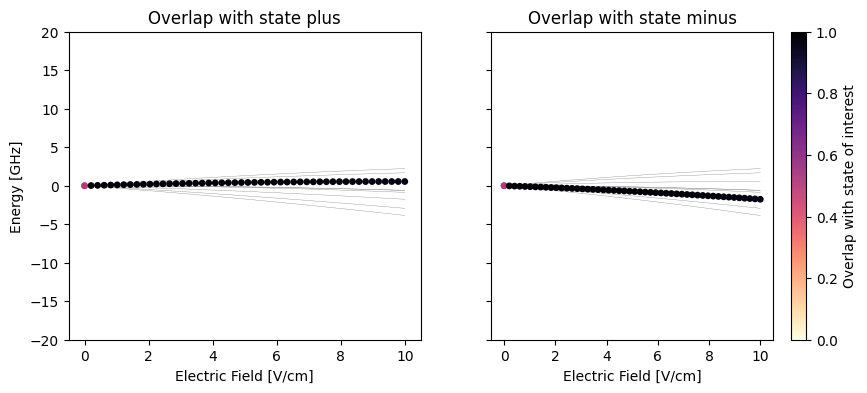

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

x_repeated = np.hstack(
    [val * np.ones_like(es) for val, es in zip(electric_fields, eigenenergies)]
)
energies_flattened = np.hstack(eigenenergies)

for i, ax in enumerate(axs):
    try:
        ax.plot(electric_fields, np.array(eigenenergies), c="0.5", lw=0.25, zorder=-10)
    except ValueError:  # inhomogeneous shape -> no simple line plot possible
        for x, es in zip(electric_fields, eigenenergies):
            ax.plot([x] * len(es), es, c="0.5", ls="None", marker=".", zorder=-10)

    if i == 0:
        ax.set_title("Overlap with state plus")
        overlaps_flattened = np.hstack(overlaps_plus)
    else:
        ax.set_title("Overlap with state minus")
        overlaps_flattened = np.hstack(overlaps_minus)

    sorter = np.argsort(overlaps_flattened)

    scat = ax.scatter(
        x_repeated[sorter],
        energies_flattened[sorter],
        c=overlaps_flattened[sorter],
        s=15,
        vmin=0,
        vmax=1,
        cmap=alphamagma,
    )

fig.colorbar(scat, ax=axs[1], label="Overlap with state of interest")

for ax in axs:
    ax.set_xlabel("Electric Field [V/cm]")
    ax.set_ylim(-20, 20)
axs[0].set_ylabel("Energy [GHz]")

plt.show()